# Model Inference
## Functions and data loading

In [10]:
import json
import os

def load_json(json_path):
    with open(json_path, 'r', encoding='utf-8') as file:
        nuc_info = json.load(file)

    return nuc_info['nuc']


def merge_cell_annotations(annotation_dict, json_folder, prefix=""):
    merged = {}
    cell_id = 0  # Start counting cells from 0

    for full_tile_id, tile_info in annotation_dict.items():
        # Extract the numeric tile ID to match the json filename
        tile_id = full_tile_id.split("_")[-1]
        tile_name = f"{prefix}{tile_id}"
        json_path = os.path.join(json_folder, f"{tile_name}.json")

        if not os.path.exists(json_path):
            print(f"Warning: JSON file for tile {tile_name} not found. Skipping.")
            continue

        with open(json_path, 'r') as f:
            json_data = json.load(f)

        nuc_dict = json_data.get('nuc', {})
        probs = tile_info['prob']
        coords = tile_info['cell_coords']

        # Sanity check
        if len(nuc_dict) != len(probs):
            print(f"Warning: Mismatch in cell count for tile {tile_name}")
            continue

        for i, (_, nuc_info) in enumerate(nuc_dict.items()):
            merged[cell_id] = {
                'prob': probs[i],
                'centroid': coords[i],  # same as 'cell_coords'
                'tile_id': tile_name,
                'contour': nuc_info['contour']
            }
            cell_id += 1

    return merged


def convert_to_global_coordinates(cell_dict, tile_centroids, tile_ids, tile_size=(224, 224)):
    """
    Convert local tile coordinates of cells to global H&E image coordinates.
    
    Args:
        cell_dict (dict): dictionary with structure {cell_id: {'centroid': [x, y], 'tile_id': ...}}
        tile_centroids (np.ndarray): array of tile centers in H&E image, shape (N, 2)
        tile_ids (pd.Series or list): tile IDs corresponding to the tile_centroids
        tile_size (tuple): size of the tile used during extraction (height, width)

    Returns:
        dict: updated dictionary with new 'global_centroid' and 'global_contour' field added for each cell
    """
    tile_to_center = {str(tile_id): center for tile_id, center in zip(tile_ids, tile_centroids)}

    height, width = tile_size
    updated_dict = {}

    for cell_id, cell_data in cell_dict.items():
        tile_id = str(cell_data["tile_id"])
        local_x, local_y = cell_data["centroid"]  # coordinates within the tile
        if tile_id not in tile_to_center:
            raise ValueError(f"tile ID {tile_id} not found in tile-to-center mapping.")

        center_x, center_y = tile_to_center[tile_id]

        # Compute top-left corner of the tile in the global H&E image
        top_left_x = center_x - height // 2
        top_left_y = center_y - width // 2

        # Convert to global coordinates
        global_x = top_left_x + local_x
        global_y = top_left_y + local_y
        
        global_contour = [
                [top_left_x + x, top_left_y + y]
                for x, y in cell_data["contour"]
            ]

        updated_dict[cell_id] = {
            **cell_data,
            "global_centroid": [global_x, global_y],
            "global_contour": global_contour
        }

    return updated_dict

In [11]:
import pickle as pkl

GLOBAL_PATH = '../../benchmark/results/HistoCell/Xenium_FFPE_Human_Breast_Cancer_Rep1'
slide_name = 'Rep1_256_3types_hires'
seed = 0
pred_path = os.path.join(GLOBAL_PATH, slide_name, f'seed_{seed}', 'preds', f'epoch_40_{slide_name}_val.pkl')

with open(pred_path, 'rb') as file:
    val_results = pkl.load(file)

for key, value in val_results.items():
    print(value.keys())
    break

dict_keys(['prob', 'pred_proportion', 'prior_type', 'cell_num', 'cell_coords'])


In [12]:
# import pandas as pd
# spot_prop_df = pd.read_csv(f'/home/luca/Documents/data/Xenium_FFPE_Human_Breast_Cancer_Rep1/histocell/BRCA/cell_proportion/type/Xenium/{slide_name}.tsv', sep="\t", index_col=0)
# ct_list = list(spot_prop_df.columns)
# list_keys = list(val_results.keys())

## Analysis

In [ ]:
value_count = 7*[0]
for key, value in val_results.items():
    cell_types = value['prob'].argmax(axis=1)
    for cell_type in cell_types:
        value_count[cell_type] += 1
print(value_count)

[53069, 1559, 32060, 3339, 9454, 2054, 0]


In [ ]:
# only if you infer on training set
tile_id = 648
spot_id = list_keys[tile_id].split('_')[-1]
df = spot_prop_df[spot_prop_df.index == int(list_keys[tile_id].split('_')[-1])]
df.loc['pred'] = val_results[list_keys[tile_id]]['pred_proportion']
df

/tmp/ipykernel_643201/1495622020.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc['pred'] = val_results[list_keys[tile_id]]['pred_proportion']


,Tumor_Cells,Macrophages,Stromal_Cells,Myoepithelial_Cells,T_Cells,Endothelial_Cells,B_Cells
3657,0.818182,0.181818,0.00000,0.000000,0.000000,0.000000,0.000000
pred,0.994065,0.001677,0.00219,0.000407,0.000899,0.000716,0.000044


Tile Name: 3365


/tmp/ipykernel_643201/2574507634.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(ct_list))


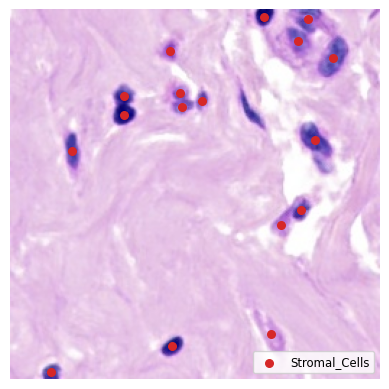

In [176]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

tile_id = 0
tile_name = list_keys[tile_id].split('_')[-1]
print(f"Tile Name: {tile_name}")

img_path = f'/home/luca/Documents/data/Xenium_FFPE_Human_Breast_Cancer_Rep1/histocell/BRCA/tiles/{slide_name}'
img = Image.open(f"{img_path}/{tile_name}.jpg").convert('RGB')

coords = val_results[list_keys[tile_id]]['cell_coords']
cell_type_indices = val_results[list_keys[tile_id]]['prob'].argmax(axis=1)
unique_indices = np.unique(cell_type_indices)
colors = plt.cm.get_cmap('tab20', len(ct_list))

plt.imshow(img)
plt.axis('off')

plotted_labels = set()

for i, (x, y) in enumerate(coords):
    idx = cell_type_indices[i]
    label = ct_list[idx]
    color = colors(idx)
    if label not in plotted_labels:
        plt.scatter(x, y, color=color, s=30, label=label)
        plotted_labels.add(label)
    else:
        plt.scatter(x, y, color=color, s=30)

plt.legend(loc='lower right', fontsize='small')
plt.show()

## Adapt to my predictions
The global objective is to compare my predictions with HistoCell's predictions. To do so, we need to know which 'HistoCell' cells correspond to which cells in my semi-simulated dataset. The first step is to add contour information in the dictionnary provided by HistoCell :

In [13]:
import scanpy as sc

path_sim = "/home/luca/Documents/data/Xenium_FFPE_Human_Breast_Cancer_Rep1/sim"
path_ST_adata = os.path.join(path_sim, 'pseudo_adata_real.h5ad')
adata = sc.read_h5ad(path_ST_adata)
adata_name = 'Xenium_FFPE_Human_Breast_Cancer_Rep1'

json_folder = f'/home/luca/Documents/data/Xenium_FFPE_Human_Breast_Cancer_Rep1/histocell/BRCA/seg/{slide_name}/json'

/cluster/CBIO/home/lgortana/anaconda3/envs/xenium-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/home/luca/Documents/data/Xenium_FFPE_Human_Breast_Cancer_Rep1/sim/pseudo_adata_real.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
pred_dict = merge_cell_annotations(val_results, json_folder, prefix='')

Then we want to convert HistoCell coordinates into global coordinates. Indeed, coordinates in HistoCell's dictionnary are relative to tiles, but tiles were extracted from an big histological slide. To receover the original cell coordinates, we do the following :

In [6]:
# # only if you infer on training set
tile_centroids = adata.obsm["spatial"].astype("int64")
tile_ids = adata.obs["spot_id"]

# centroids_file = f'/home/luca/Documents/data/Xenium_FFPE_Human_Breast_Cancer_Rep1/histocell/BRCA/tiles/{slide_name}/tile_centroids.csv'
# tile_centroids_df = pd.read_csv(centroids_file, index_col=0, sep=' ')

# tile_ids = [f'tile_{list_keys[i].split("_")[-1]}' for i in range(len(list_keys))]
# tile_centroids = np.array([tile_centroids_df.loc[tile_id].values for tile_id in tile_ids])

pred_dict_global = convert_to_global_coordinates(pred_dict, tile_centroids, tile_ids, tile_size=(256, 256))

Now I want to map 'HistoCell' cells to my cells. So I need to load my hovernet dictionnary and my ground truth (I filter the segmentation dict with my ground truth index). Then I see which cells from my hovernet dictionnary are close to which 'HistoCell' cells, and I build an assignment dictionnary. To be sure cells correspond to each other, I only keep cells with an IoU that is higher than a specified threshold :

In [7]:
path_sim_seg = os.path.join(path_sim, 'pannuke_fast_mask_lvl3_annotated.json')
nuc_info_global = load_json(path_sim_seg)

path_gt = os.path.join(path_sim, 'sim_Xenium_FFPE_Human_Breast_Cancer_Rep1_gt.csv')
ground_truth = pd.read_csv(path_gt, index_col=0)
ground_truth.index = ground_truth.index.astype(str)

filtered_hovernet = {
    k: v for k, v in nuc_info_global.items() if k in ground_truth.index
}

In [8]:
from scipy.spatial import cKDTree
from shapely.geometry import Polygon
import numpy as np

overlap_threshold = 0.3

# Prepare centroid arrays
seg_keys = list(filtered_hovernet.keys())
seg_centroids = np.array([filtered_hovernet[k]['centroid'] for k in seg_keys])

pred_keys = list(pred_dict_global.keys())
pred_centroids = np.array([pred_dict_global[k]['global_centroid'] for k in pred_keys])

seg_tree = cKDTree(seg_centroids)

assignments = {}
assignment_distances = []
used_seg_indices = set()
used_pred_indices = set()

for i, pred_centroid in enumerate(pred_centroids):
    # Query all segmentation centroids sorted by distance
    dists, idxs = seg_tree.query(pred_centroid, k=min(10, len(seg_centroids)))
    if np.isscalar(dists):
        dists = [dists]
        idxs = [idxs]

    for dist, seg_idx in zip(dists, idxs):
        if seg_idx not in used_seg_indices:
            # Check contour overlap (IoU)
            pred_polygon = Polygon(pred_dict_global[pred_keys[i]]['global_contour'])
            seg_polygon = Polygon(filtered_hovernet[seg_keys[seg_idx]]['contour'])

            if not pred_polygon.is_valid or not seg_polygon.is_valid:
                continue

            intersection_area = pred_polygon.intersection(seg_polygon).area
            union_area = pred_polygon.union(seg_polygon).area
            iou = intersection_area / union_area if union_area > 0 else 0

            if iou > overlap_threshold:
                assignments[pred_keys[i]] = seg_keys[seg_idx]
                used_seg_indices.add(seg_idx)
                used_pred_indices.add(i)
                assignment_distances.append(dist)
                break

In [9]:
len(assignments)

86057

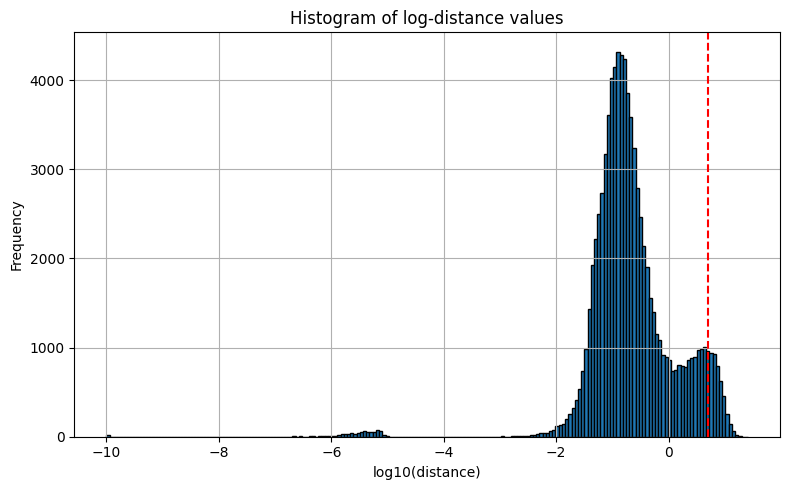

In [10]:
import numpy as np
import matplotlib.pyplot as plt

log_distances = np.log10([d if d > 0 else 1e-10 for d in assignment_distances])

plt.figure(figsize=(8, 5))
plt.hist(log_distances, bins=200, edgecolor='black')
plt.axvline(x=np.log10(5), color='red', linestyle='--', label='distance = 1')
plt.xlabel('log10(distance)')
plt.ylabel('Frequency')
plt.title('Histogram of log-distance values')
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
keys = set(assignments.keys())
values = set(assignments.values())
print("Bijection respected : ", len(keys) == len(values) and len(assignments) == len(keys))

Bijection respected :  True


We can see that all distances are very small (< 5 pixels), the bijection is respected and we have a satisfying amount of remaining cells. We can then transform HistoCell output into a prediction DataFrame and save it :

In [12]:
rows = []
index = []

for pred_key, nucleus_id in assignments.items():
    pred = pred_dict_global.get(pred_key)
    if pred is None:
        continue
    probs = pred['prob']
    rows.append(probs)
    index.append(int(nucleus_id))

pred_histocell = pd.DataFrame(rows, columns=ct_list, index=index)
pred_histocell.index.name = 'nucleus_id'
pred_histocell

,Tumor_Cells,Macrophages,Stromal_Cells,Myoepithelial_Cells,T_Cells,Endothelial_Cells,B_Cells
nucleus_id,,,,,,,
61845,0.000018,0.000366,0.998481,4.366241e-06,0.000138,0.000535,0.000458
61859,0.000108,0.000363,0.996835,2.382513e-05,0.000083,0.002126,0.000462
61870,0.000016,0.000461,0.998194,1.371655e-05,0.000104,0.000955,0.000255
61875,0.000015,0.000147,0.997517,1.410443e-05,0.000023,0.002106,0.000179
61882,0.000007,0.000080,0.999777,7.810445e-07,0.000027,0.000032,0.000077
...,...,...,...,...,...,...,...
159033,0.754988,0.001776,0.230527,5.416136e-03,0.005194,0.001843,0.000256
170328,0.757874,0.004297,0.049388,1.742161e-01,0.001970,0.012016,0.000239
170330,0.287733,0.004764,0.600983,6.961198e-02,0.027350,0.008087,0.001471


In [ ]:
output_path = f'../../benchmark/results/HistoCell/{adata_name}/{slide_name}/seed_{seed}/pred_histocell.csv'
pred_histocell.to_csv(output_path, index=True)

Let's also save a new version of the HoVerNet dict with HistoCell annotation :

In [187]:
new_nuc_info_global = nuc_info_global.copy()
for key in nuc_info_global:
    nucleus_id = int(key)
    if nucleus_id in pred_histocell.index:
        max_type = ground_truth.loc[str(nucleus_id)].values.argmax()
        new_nuc_info_global[key]['type'] = int(max_type)
    else:
        new_nuc_info_global[key]['type'] = pred_histocell.shape[1]
        
new_nuc_info_global = {'mag' : None, 'nuc': new_nuc_info_global}

In [ ]:
output_path = f'../../benchmark/results/HistoCell/{adata_name}/{slide_name}/seed_{seed}/pannuke_fast_mask_lvl3_annotated_filtered.json'
with open(output_path, 'w') as json_file:
    json.dump(new_nuc_info_global, json_file)

## Spot prediction performance

There is no need to filter cells in spots. The predictions come with the predicted spot proportion, so let's compare them with the ground truth :

In [102]:
import os
import csv
import numpy as np
from openpyxl import load_workbook

def compute_statistics(metrics_list):
    """
    Compute mean and confidence intervals for a list of metrics.

    Args:
        metrics_list (List[Dict[str, float]]): List of dictionaries containing metrics from each run.

    Returns:
        Tuple[Dict[str, float], Dict[str, float]]: Tuple containing the mean and confidence intervals for each metric.
    """

    df_metrics = pd.DataFrame(metrics_list)
    mean_values = df_metrics.mean().to_dict()
    std_values = df_metrics.std()
    count_values = df_metrics.count()
    se_values = std_values / np.sqrt(count_values)
    ci_values = {f"{key} ci": 1.96 * se for key, se in se_values.items()}

    return mean_values, ci_values


def save_metrics_to_excel(metrics_dict, seed, excel_path):
    new_row = {'seed': seed, **metrics_dict}

    if os.path.exists(excel_path):
        # Load existing Excel file
        book = load_workbook(excel_path)
        per_run_df = pd.read_excel(excel_path, sheet_name='per_run')
        per_run_df = pd.concat([per_run_df, pd.DataFrame([new_row])], ignore_index=True)

        # Compute summary
        metric_keys = [k for k in new_row.keys() if k != 'seed']
        metric_dicts = per_run_df[metric_keys].to_dict(orient='records')
        mean_vals, ci_vals = compute_statistics(metric_dicts)

        summary_row = {**mean_vals, **ci_vals}
        summary_df = pd.DataFrame([summary_row])

        with pd.ExcelWriter(excel_path, engine='openpyxl', mode='w') as writer:
            # Ensure summary is first sheet
            summary_df.to_excel(writer, sheet_name='summary', index=False)
            per_run_df.to_excel(writer, sheet_name='per_run', index=False)
    else:
        # Create new Excel file
        per_run_df = pd.DataFrame([new_row])
        metric_keys = [k for k in new_row.keys() if k != 'seed']
        metric_dicts = per_run_df[metric_keys].to_dict(orient='records')
        mean_vals, ci_vals = compute_statistics(metric_dicts)
        summary_row = {**mean_vals, **ci_vals}
        summary_df = pd.DataFrame([summary_row])

        with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
            summary_df.to_excel(writer, sheet_name='summary', index=False)
            per_run_df.to_excel(writer, sheet_name='per_run', index=False)

In [103]:
adata_name = 'Xenium_FFPE_Human_Breast_Cancer_Rep1'

In [104]:
pred_spot_df = pd.DataFrame(index=spot_prop_df.index, columns=ct_list)

for tile_id, value in val_results.items():
    spot_id = tile_id.split('_')[-1]
    pred = value['pred_proportion']
    pred_spot_df.loc[int(spot_id)] = pred

pred_spot_df = pred_spot_df.dropna()
spot_prop_df = spot_prop_df.loc[pred_spot_df.index]

In [105]:
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

metrics = {}

pearson_list = []
spearman_list = []
mse_list = []
mae_list = []

for cell_type in spot_prop_df.columns:
    true_col = spot_prop_df[cell_type].values
    pred_col = pred_spot_df[cell_type].values

    if np.std(true_col) > 0 and np.std(pred_col) > 0:  # Ensure non-constant values
        pearson_corr = pearsonr(true_col, pred_col)[0]
        spearman_corr = spearmanr(true_col, pred_col)[0]
    else:
        pearson_corr = np.nan
        spearman_corr = np.nan

    mse_value = mean_squared_error(true_col, pred_col)
    mae_value = mean_absolute_error(true_col, pred_col)

    metrics[f"Pearson Correlation {cell_type}"] = pearson_corr
    metrics[f"Spearman Correlation {cell_type}"] = spearman_corr
    metrics[f"MSE {cell_type}"] = mse_value
    metrics[f"MAE {cell_type}"] = mae_value

    pearson_list.append(pearson_corr)
    spearman_list.append(spearman_corr)
    mse_list.append(mse_value)
    mae_list.append(mae_value)

metrics["Pearson Correlation global"] = np.nanmean(pearson_list)
metrics["Spearman Correlation global"] = np.nanmean(spearman_list)
metrics["MSE global"] = np.mean(mse_list)
metrics["MAE global"] = np.mean(mae_list)

In [106]:
metrics = {'Pearson Correlation global': metrics['Pearson Correlation global'],
           'Spearman Correlation global': metrics['Spearman Correlation global'],
           'MSE global': metrics['MSE global'],
           'MAE global': metrics['MAE global']}

In [ ]:
# output_path = os.path.join(f'../../benchmark/results/HistoCell/{adata_name}/{slide_name}', 'metrics_spots.xlsx')
# save_metrics_to_excel(metrics, seed, output_path)